In [1]:
import tensorflow as tf
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#load data
digits = load_digits()
X = digits.data
y = digits.target
y = LabelBinarizer().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [3]:
X.shape, y.shape

((1797, 64), (1797, 10))

In [4]:
def data_visulization_check(image_number):
    print(y[image_number])
    plt.imshow(np.reshape(X[image_number], (8,8)))

[0 0 0 0 1 0 0 0 0 0]


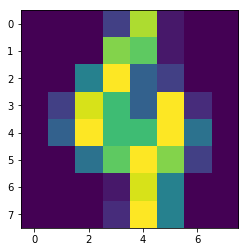

In [5]:
data_visulization_check(97)

In [6]:
def add_layer(inputs, in_size, out_size, layer_name, activation_function=None):
    #add a layer
    Weights = tf.Variable(tf.random_normal([in_size, out_size]))
    biases = tf.Variable(tf.zeros([1, out_size]) + .1)
    Wx_plus_b = tf.matmul(inputs, Weights) + biases
    #here to dropout
    Wx_plus_b = tf.nn.dropout(Wx_plus_b, keep_prob)
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    tf.summary.histogram(layer_name + '/outputs', outputs)
    return outputs

In [7]:
#define a placeholder for inputs to network
keep_prob = tf.placeholder(tf.float32)
xs = tf.placeholder(tf.float32, [None, 64]) # 8x8
ys = tf.placeholder(tf.float32, [None, 10])

In [8]:
# add output layer
l1 = add_layer(xs, 64, 50, 'l1', activation_function=tf.nn.tanh)
prediction = add_layer(l1, 50, 10, 'l2', activation_function=tf.nn.softmax)

In [9]:
# the loss between prediction and real data
cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction),
                                             reduction_indices=[1])) #loss
tf.summary.scalar('loss', cross_entropy)
train_step = tf.train.GradientDescentOptimizer(.5).minimize(cross_entropy)

sess = tf.Session()
merged = tf.summary.merge_all()

In [10]:
#summary writer for tensor board
train_writer = tf.summary.FileWriter("logs/train", sess.graph)
test_writer = tf.summary.FileWriter("logs/test", sess.graph)

In [11]:
# tf.initialize_all_variables() no long valid from
# 2017-03-02 if using tensorflow >= 0.12
if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
    init = tf.initialize_all_variables()
else:
    init = tf.global_variables_initializer()
sess.run(init)

In [12]:
for i in range(500):
    # here to determine the keeping probability
    sess.run(train_step, feed_dict={xs: X_train, ys: y_train, keep_prob: 0.5})
    if i % 50 == 0:
        # record loss
        train_result = sess.run(merged, feed_dict={xs: X_train, ys: y_train, keep_prob: 1})
        test_result = sess.run(merged, feed_dict={xs: X_test, ys: y_test, keep_prob: 1})
        train_writer.add_summary(train_result, i)
        test_writer.add_summary(test_result, i)